In [24]:
import warnings
import pandas as pd
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Data Retrieval 

In the code cell below, we will first import all relevant packages we will need for our data analyses and visualisations. These include matplotlib.pyplot (plt), numpy (np), pandas (pd),  seaborn (sns), yfinance (yf) and the "minimize" function from scipy. The latter will allow us to download stock price data from Yahoo Finance. 

The last line of code will set the style for all plots created with matplotlib to ggplot. 

In [25]:
#Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize

#Set the style for plots
plt.style.use("ggplot")

Next, we will prepare our data frame, which will include the 2020-2024 data for 10 stocks, namely: 
- Amazon (AMZN)
- Tesla (TSLA)
- JPMorgan (JPM)
- Walmart (WMT)
- Visa (V)
- Netflix (NFLX)
- Exxon Mobil (XOM)
- Procter & Gamble (PG)
- Johnson & Johnson (JNJ)
- Coca-Cola (KO)

We will pull the data from Yahoo Finance and save it to a single CSV file. 

In [26]:
#Download data from Yahoo Finance
tickers = ["AMZN", "TSLA", "JPM", "WMT", "V", "NFLX", "XOM", "PG", "JNJ", "KO"]
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")

#Create a separate "Ticker" column 
df = data.stack(level=1).reset_index()

#Rearrange so that all tickers of one company are shown before the tickers of the next company
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

#Save to a CSV file 
df.to_csv("portfolio_data.csv", index=False)

#Check date format
print("The date format is: \n", df.Date.head())

#Load the data
df = pd.read_csv("portfolio_data.csv")

#Convert to a datetime object
df["Date"] = pd.to_datetime(df["Date"])

[*********************100%***********************]  10 of 10 completed


The date format is: 
 0   2020-01-02
1   2020-01-03
2   2020-01-06
3   2020-01-07
4   2020-01-08
Name: Date, dtype: datetime64[ns]


# Data Cleaning
Having prepared our data frame, we will make sure it does not contain any missing values or duplicates, and the index for each ticker is in ascending order. 

In [27]:
#Check for missing values
print("Missing data:", df.isnull().sum().sum())

#Check for ascending order in the index by ticker 
order = df.groupby("Ticker")["Date"].apply(lambda x: x.is_monotonic_increasing)
print("In ascending order:\n", order)

#Check for duplicates
print("Number of duplicates:", df.duplicated().sum())

Missing data: 0
In ascending order:
 Ticker
AMZN    True
JNJ     True
JPM     True
KO      True
NFLX    True
PG      True
TSLA    True
V       True
WMT     True
XOM     True
Name: Date, dtype: bool
Number of duplicates: 0


# Data Exploration
Now, let's explore the data. We will identify the closing prices for each stock and plot them over the 2020-2024 period.

Head: Ticker           AMZN         JNJ         JPM         KO        NFLX  \
Date                                                                   
2020-01-02  94.900497  124.983704  120.733528  46.419697  329.809998   
2020-01-03  93.748497  123.536652  119.140335  46.166447  325.899994   
2020-01-06  95.143997  123.382561  119.045563  46.149574  335.829987   
2020-01-07  95.343002  124.135986  117.021729  45.795029  330.750000   
2020-01-08  94.598503  124.118904  117.934631  45.879448  339.260010   

Ticker              PG       TSLA           V        WMT        XOM  
Date                                                                 
2020-01-02  107.748230  28.684000  183.872055  36.593372  54.634789  
2020-01-03  107.023582  29.534000  182.409714  36.270329  54.195553  
2020-01-06  107.172012  30.102667  182.015259  36.196484  54.611675  
2020-01-07  106.508461  31.270666  181.534195  35.861141  54.164722  
2020-01-08  106.962463  32.809334  184.641724  35.738068  53.347897  

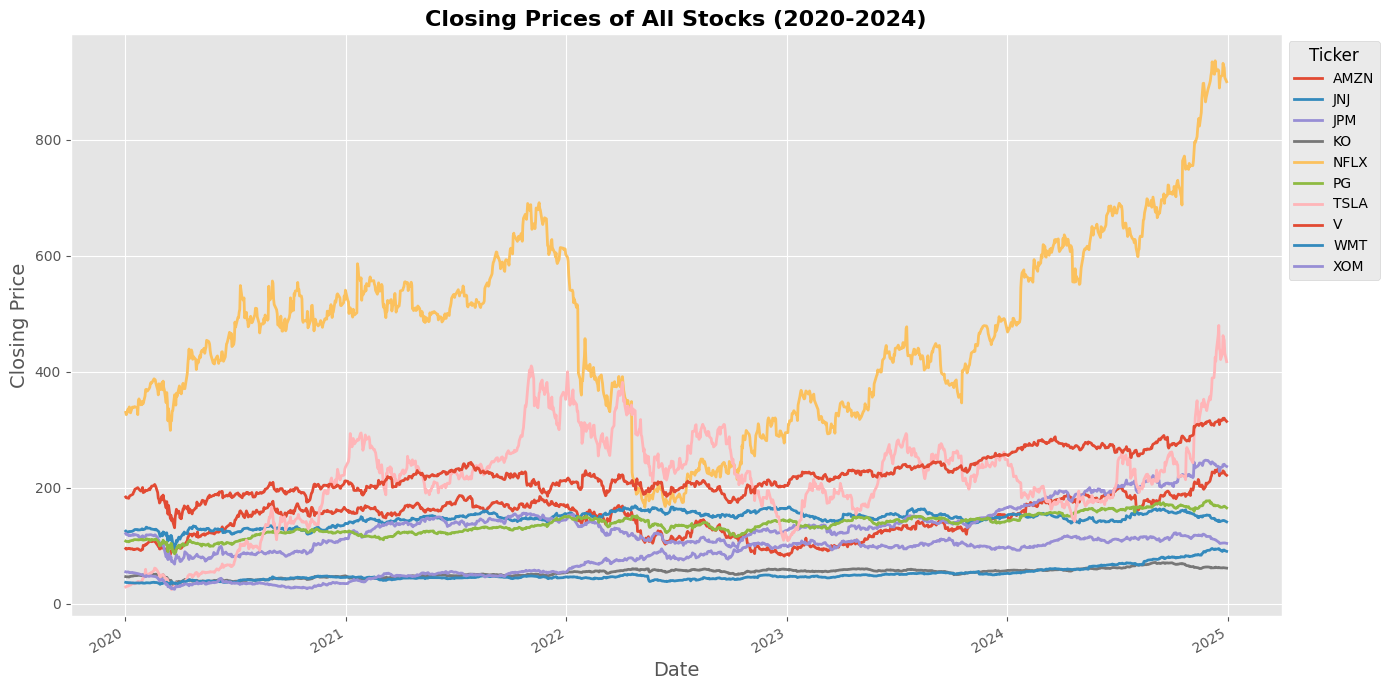

In [28]:
#Pivot table with closing prices 
pivot_df = df.pivot(index="Date", columns="Ticker", values="Close")

# Show the head
print("Head:", pivot_df.head())

# Show the tail
print("\nTail:", pivot_df.tail())

#Plot 
plot = pivot_df.plot(figsize=(14, 7), linewidth=2)
plot.set_title("Closing Prices of All Stocks (2020-2024)", fontsize=16, fontweight='bold')
plot.set_ylabel("Closing Price", fontsize=14)
plot.set_xlabel("Date", fontsize=14)
plot.legend(title="Ticker", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Backtesting - Bollinger Bands Mean Reversion Strategy

For each stock, we will now implement and backtest the Bollinger Bands Mean Reversion strategy to leverage the tendency of stock prices to revert to their mean. 

To do so, we will first subset each stock and set up our middle Bollinger Band (20-day SMA), as well as our upper and lower Bollinger Bands at two standard deviations from the middle band. Then, we will generate entry, hold, and exit signals according to the Bollinger Bands Mean Reversion strategy. Finally, we will compare the cumulative return for this strategy to that of the Buy & Hold strategy.

We will start with Amazon:

           Ticker        BH      BBMR
Date                                 
2024-12-30   AMZN  1.331916 -0.021689


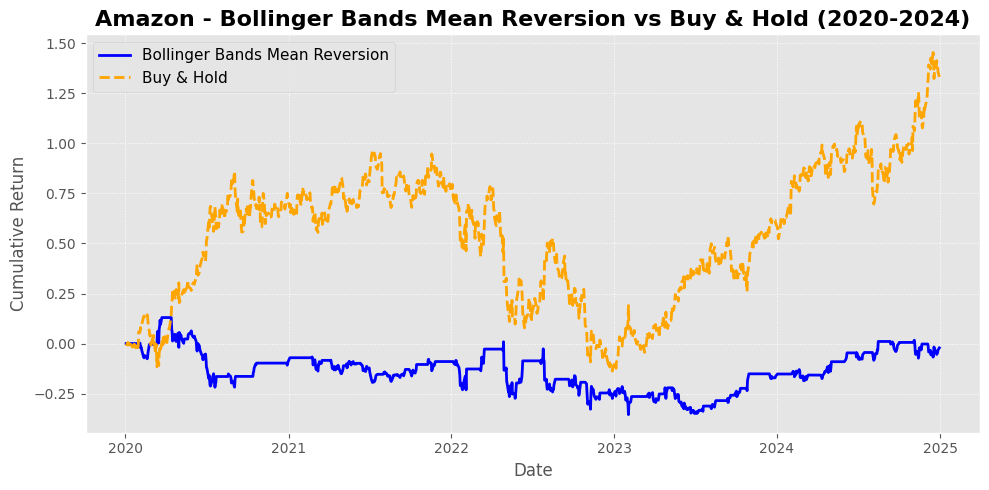

In [29]:
#Subset Amazon: 
AMZN = df.groupby("Ticker").get_group("AMZN").copy() 
AMZN.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
AMZN["SMA"] = AMZN.Close.rolling(window=20).mean()
AMZN["Dev"] = AMZN.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
AMZN["UpperBand"] = AMZN.SMA + (2 * AMZN.Dev)
AMZN["LowerBand"] = AMZN.SMA - (2 * AMZN.Dev)

#Generate entry and exit signals 
AMZN["Signal"] = np.nan
signal = 0  
for row in range(1, len(AMZN)):
	close = AMZN.Close.iloc[row]
	prev_close = AMZN.Close.iloc[row-1]
	sma = AMZN.SMA.iloc[row]
	prev_sma = AMZN.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < AMZN.LowerBand.iloc[row]:
			AMZN.Signal.iloc[row] = 1
			signal = 1
		elif close > AMZN.UpperBand.iloc[row]:
			AMZN.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			AMZN.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			AMZN.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
AMZN.Signal = AMZN.Signal.ffill()

#No trade (0), if there is no signal 
AMZN.Signal = AMZN.Signal.fillna(0)

#Calculate the simple daily returns 
AMZN["Returns"] = AMZN.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
AMZN["Position"] = AMZN.Signal.shift()
AMZN["Strategy"] = AMZN.Returns * AMZN.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
AMZN["BBMR"] = (1 + AMZN.Strategy).cumprod() - 1
AMZN["BH"] = (1 + AMZN.Returns).cumprod() - 1 
print(AMZN.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(AMZN.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(AMZN.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Amazon - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Tesla's stock:

           Ticker         BH      BBMR
Date                                  
2024-12-30   TSLA  13.552015 -0.957668


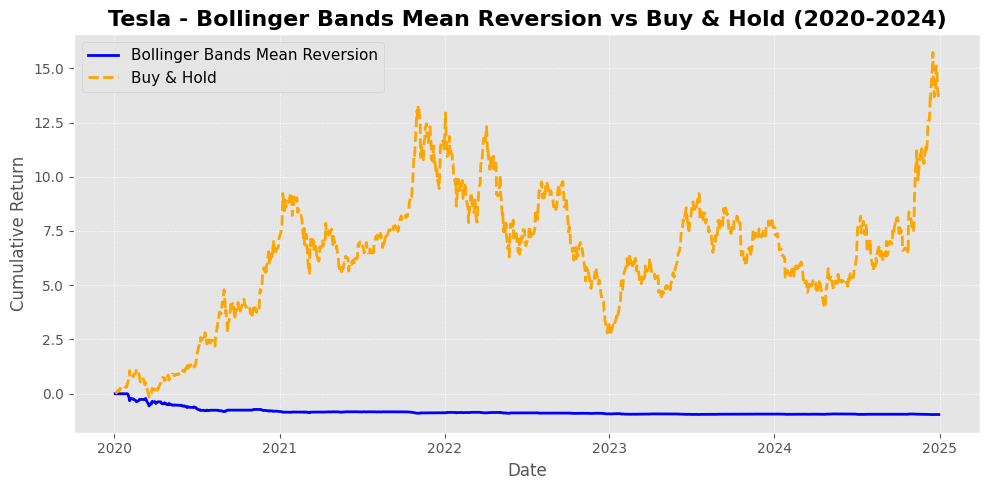

In [30]:
#Subset Tesla 
TSLA = df.groupby("Ticker").get_group("TSLA").copy() 
TSLA.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
TSLA["SMA"] = TSLA.Close.rolling(window=20).mean()
TSLA["Dev"] = TSLA.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
TSLA["UpperBand"] = TSLA.SMA + (2 * TSLA.Dev)
TSLA["LowerBand"] = TSLA.SMA - (2 * TSLA.Dev)

#Generate entry and exit signals 
TSLA["Signal"] = np.nan
signal = 0  
for row in range(1, len(TSLA)):
	close = TSLA.Close.iloc[row]
	prev_close = TSLA.Close.iloc[row-1]
	sma = TSLA.SMA.iloc[row]
	prev_sma = TSLA.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < TSLA.LowerBand.iloc[row]:
			TSLA.Signal.iloc[row] = 1
			signal = 1
		elif close > TSLA.UpperBand.iloc[row]:
			TSLA.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			TSLA.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			TSLA.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
TSLA.Signal = TSLA.Signal.ffill()

#No trade (0), if there is no signal 
TSLA.Signal = TSLA.Signal.fillna(0)

#Calculate the simple daily returns 
TSLA["Returns"] = TSLA.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
TSLA["Position"] = TSLA.Signal.shift()
TSLA["Strategy"] = TSLA.Returns * TSLA.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
TSLA["BBMR"] = (1 + TSLA.Strategy).cumprod() - 1
TSLA["BH"] = (1 + TSLA.Returns).cumprod() - 1 
print(TSLA.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(TSLA.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(TSLA.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Tesla - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to JPMorgan's stock:

           Ticker        BH      BBMR
Date                                 
2024-12-30    JPM  0.959959  0.207145


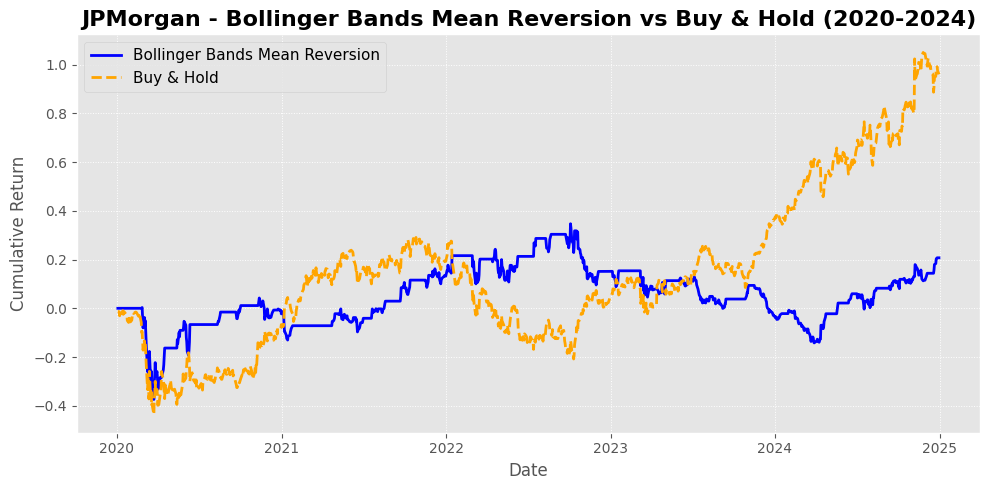

In [31]:
#Subset JPMorgan 
JPM = df.groupby("Ticker").get_group("JPM").copy() 
JPM.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
JPM["SMA"] = JPM.Close.rolling(window=20).mean()
JPM["Dev"] = JPM.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
JPM["UpperBand"] = JPM.SMA + (2 * JPM.Dev)
JPM["LowerBand"] = JPM.SMA - (2 * JPM.Dev)

#Generate entry and exit signals 
JPM["Signal"] = np.nan
signal = 0  
for row in range(1, len(JPM)):
	close = JPM.Close.iloc[row]
	prev_close = JPM.Close.iloc[row-1]
	sma = JPM.SMA.iloc[row]
	prev_sma = JPM.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < JPM.LowerBand.iloc[row]:
			JPM.Signal.iloc[row] = 1
			signal = 1
		elif close > JPM.UpperBand.iloc[row]:
			JPM.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			JPM.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			JPM.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
JPM.Signal = JPM.Signal.ffill()

#No trade (0), if there is no signal 
JPM.Signal = JPM.Signal.fillna(0)

#Calculate the simple daily returns 
JPM["Returns"] = JPM.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
JPM["Position"] = JPM.Signal.shift()
JPM["Strategy"] = JPM.Returns * JPM.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
JPM["BBMR"] = (1 + JPM.Strategy).cumprod() - 1
JPM["BH"] = (1 + JPM.Returns).cumprod() - 1 
print(JPM.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(JPM.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(JPM.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("JPMorgan - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Walmart's stock:


           Ticker        BH      BBMR
Date                                 
2024-12-30    WMT  1.462307  0.126939


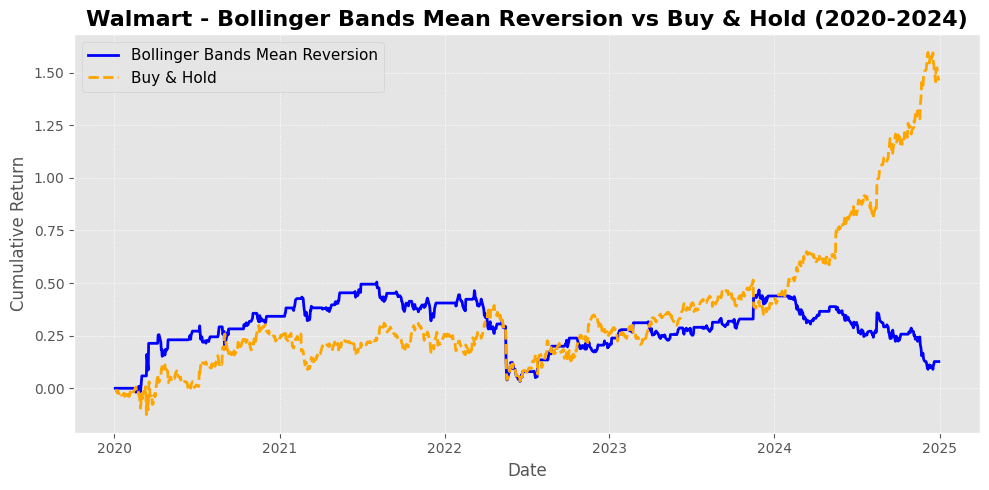

In [32]:
#Subset Walmart 
WMT = df.groupby("Ticker").get_group("WMT").copy() 
WMT.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
WMT["SMA"] = WMT.Close.rolling(window=20).mean()
WMT["Dev"] = WMT.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
WMT["UpperBand"] = WMT.SMA + (2 * WMT.Dev)
WMT["LowerBand"] = WMT.SMA - (2 * WMT.Dev)

#Generate entry and exit signals 
WMT["Signal"] = np.nan
signal = 0  
for row in range(1, len(WMT)):
	close = WMT.Close.iloc[row]
	prev_close = WMT.Close.iloc[row-1]
	sma = WMT.SMA.iloc[row]
	prev_sma = WMT.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < WMT.LowerBand.iloc[row]:
			WMT.Signal.iloc[row] = 1
			signal = 1
		elif close > WMT.UpperBand.iloc[row]:
			WMT.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			WMT.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			WMT.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
WMT.Signal = WMT.Signal.ffill()

#No trade (0), if there is no signal 
WMT.Signal = WMT.Signal.fillna(0)

#Calculate the simple daily returns 
WMT["Returns"] = WMT.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
WMT["Position"] = WMT.Signal.shift()
WMT["Strategy"] = WMT.Returns * WMT.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
WMT["BBMR"] = (1 + WMT.Strategy).cumprod() - 1
WMT["BH"] = (1 + WMT.Returns).cumprod() - 1 
print(WMT.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(WMT.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(WMT.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Walmart - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Visa's stock: 

           Ticker        BH      BBMR
Date                                 
2024-12-30      V  0.709115  0.700905


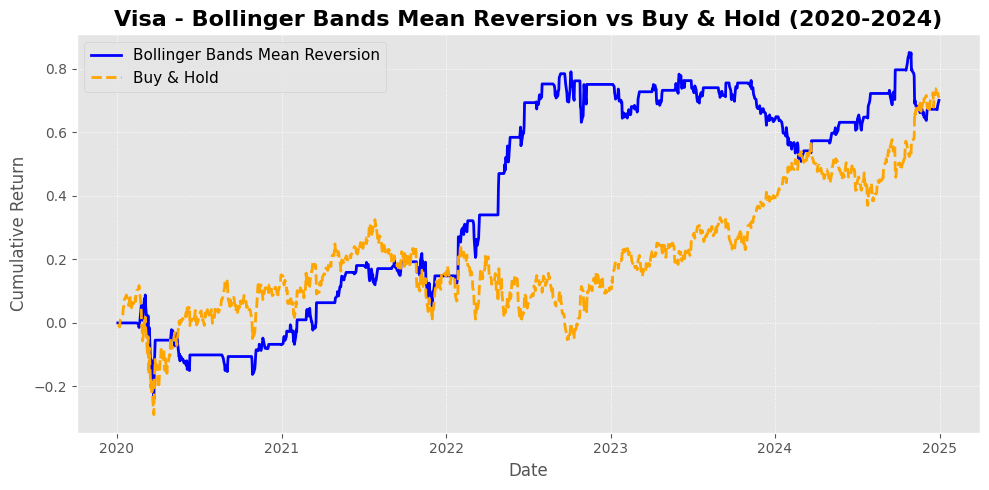

In [33]:
#Subset Visa 
V = df.groupby("Ticker").get_group("V").copy() 
V.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
V["SMA"] = V.Close.rolling(window=20).mean()
V["Dev"] = V.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
V["UpperBand"] = V.SMA + (2 * V.Dev)
V["LowerBand"] = V.SMA - (2 * V.Dev)

#Generate entry and exit signals 
V["Signal"] = np.nan
signal = 0  
for row in range(1, len(V)):
	close = V.Close.iloc[row]
	prev_close = V.Close.iloc[row-1]
	sma = V.SMA.iloc[row]
	prev_sma = V.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < V.LowerBand.iloc[row]:
			V.Signal.iloc[row] = 1
			signal = 1
		elif close > V.UpperBand.iloc[row]:
			V.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			V.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			V.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
V.Signal = V.Signal.ffill()

#No trade (0), if there is no signal 
V.Signal = V.Signal.fillna(0)

#Calculate the simple daily returns 
V["Returns"] = V.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
V["Position"] = V.Signal.shift()
V["Strategy"] = V.Returns * V.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
V["BBMR"] = (1 + V.Strategy).cumprod() - 1
V["BH"] = (1 + V.Returns).cumprod() - 1 
print(V.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(V.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(V.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Visa - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Netflix's stock:

           Ticker        BH      BBMR
Date                                 
2024-12-30   NFLX  1.730148 -0.511134


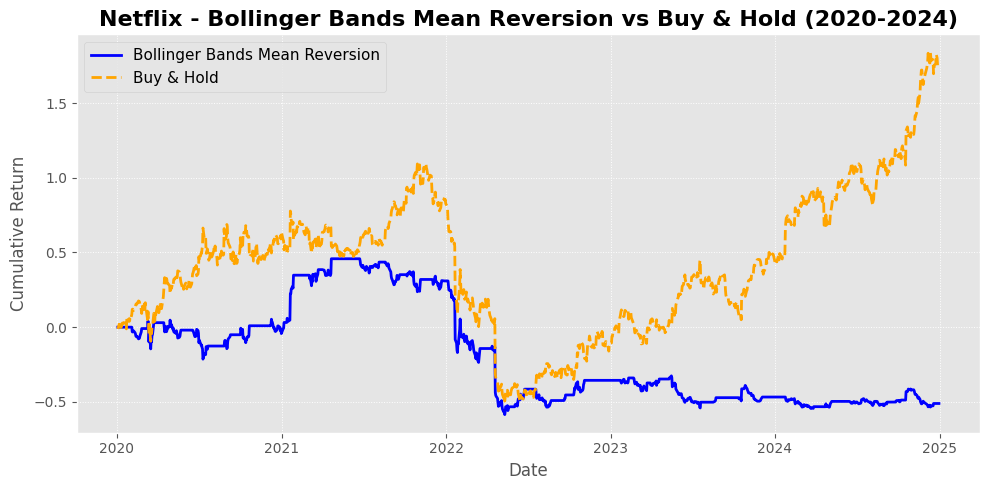

In [34]:
#Subset Netflix 
NFLX = df.groupby("Ticker").get_group("NFLX").copy() 
NFLX.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
NFLX["SMA"] = NFLX.Close.rolling(window=20).mean()
NFLX["Dev"] = NFLX.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
NFLX["UpperBand"] = NFLX.SMA + (2 * NFLX.Dev)
NFLX["LowerBand"] = NFLX.SMA - (2 * NFLX.Dev)

#Generate entry and exit signals 
NFLX["Signal"] = np.nan
signal = 0  
for row in range(1, len(NFLX)):
	close = NFLX.Close.iloc[row]
	prev_close = NFLX.Close.iloc[row-1]
	sma = NFLX.SMA.iloc[row]
	prev_sma = NFLX.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < NFLX.LowerBand.iloc[row]:
			NFLX.Signal.iloc[row] = 1
			signal = 1
		elif close > NFLX.UpperBand.iloc[row]:
			NFLX.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			NFLX.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			NFLX.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
NFLX.Signal = NFLX.Signal.ffill()

#No trade (0), if there is no signal 
NFLX.Signal = NFLX.Signal.fillna(0)

#Calculate the simple daily returns 
NFLX["Returns"] = NFLX.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
NFLX["Position"] = NFLX.Signal.shift()
NFLX["Strategy"] = NFLX.Returns * NFLX.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
NFLX["BBMR"] = (1 + NFLX.Strategy).cumprod() - 1
NFLX["BH"] = (1 + NFLX.Returns).cumprod() - 1 
print(NFLX.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(NFLX.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(NFLX.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Netflix - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Exxon Mobil's stock:

           Ticker        BH     BBMR
Date                                
2024-12-30    XOM  0.901092 -0.12427


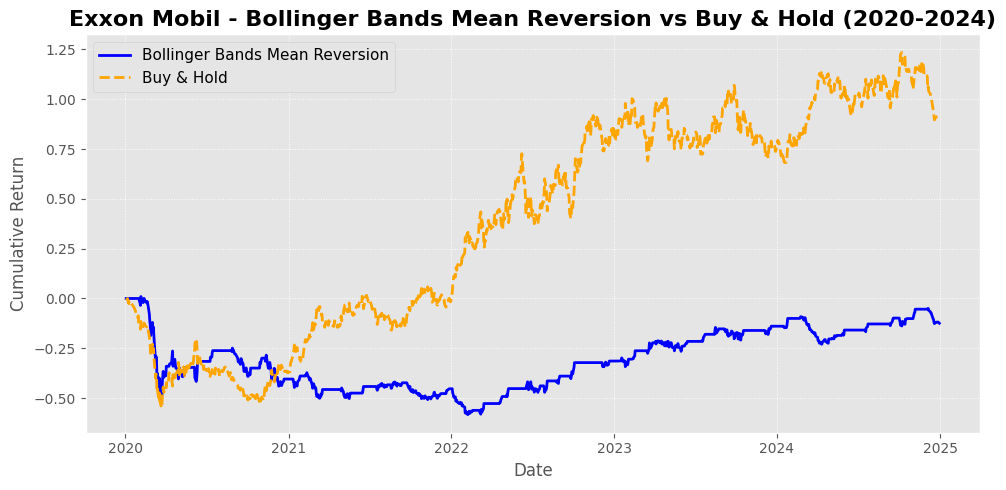

In [35]:
#Subset Exxon Mobil 
XOM = df.groupby("Ticker").get_group("XOM").copy() 
XOM.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
XOM["SMA"] = XOM.Close.rolling(window=20).mean()
XOM["Dev"] = XOM.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
XOM["UpperBand"] = XOM.SMA + (2 * XOM.Dev)
XOM["LowerBand"] = XOM.SMA - (2 * XOM.Dev)

#Generate entry and exit signals 
XOM["Signal"] = np.nan
signal = 0  
for row in range(1, len(XOM)):
	close = XOM.Close.iloc[row]
	prev_close = XOM.Close.iloc[row-1]
	sma = XOM.SMA.iloc[row]
	prev_sma = XOM.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < XOM.LowerBand.iloc[row]:
			XOM.Signal.iloc[row] = 1
			signal = 1
		elif close > XOM.UpperBand.iloc[row]:
			XOM.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			XOM.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			XOM.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
XOM.Signal = XOM.Signal.ffill()

#No trade (0), if there is no signal 
XOM.Signal = XOM.Signal.fillna(0)

#Calculate the simple daily returns 
XOM["Returns"] = XOM.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
XOM["Position"] = XOM.Signal.shift()
XOM["Strategy"] = XOM.Returns * XOM.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
XOM["BBMR"] = (1 + XOM.Strategy).cumprod() - 1
XOM["BH"] = (1 + XOM.Returns).cumprod() - 1 
print(XOM.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(XOM.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(XOM.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Exxon Mobil - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Procter & Gamble's stock:

           Ticker        BH      BBMR
Date                                 
2024-12-30     PG  0.531798 -0.159844


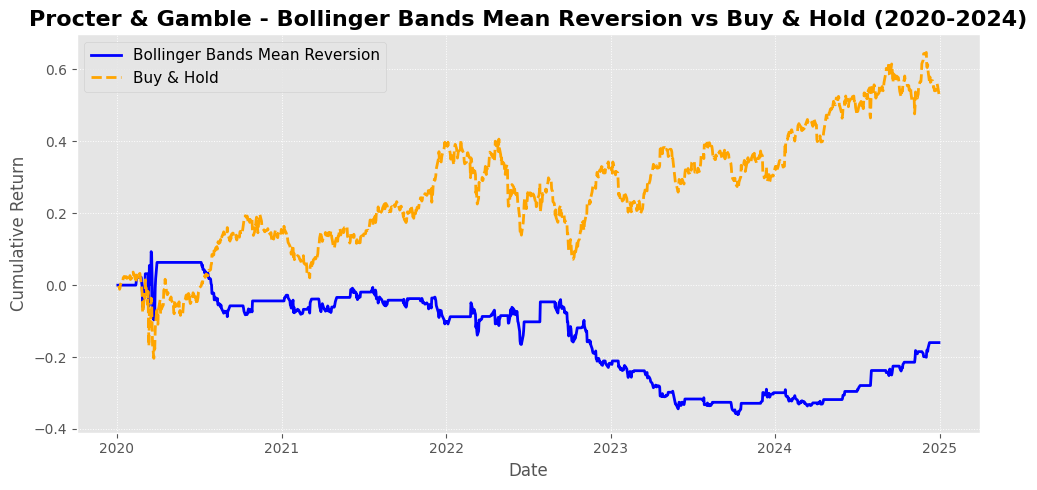

In [36]:
#Subset Procter & Gamble
PG = df.groupby("Ticker").get_group("PG").copy() 
PG.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
PG["SMA"] = PG.Close.rolling(window=20).mean()
PG["Dev"] = PG.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
PG["UpperBand"] = PG.SMA + (2 * PG.Dev)
PG["LowerBand"] = PG.SMA - (2 * PG.Dev)

#Generate entry and exit signals 
PG["Signal"] = np.nan
signal = 0  
for row in range(1, len(PG)):
	close = PG.Close.iloc[row]
	prev_close = PG.Close.iloc[row-1]
	sma = PG.SMA.iloc[row]
	prev_sma = PG.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < PG.LowerBand.iloc[row]:
			PG.Signal.iloc[row] = 1
			signal = 1
		elif close > PG.UpperBand.iloc[row]:
			PG.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			PG.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			PG.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
PG.Signal = PG.Signal.ffill()

#No trade (0), if there is no signal 
PG.Signal = PG.Signal.fillna(0)

#Calculate the simple daily returns 
PG["Returns"] = PG.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
PG["Position"] = PG.Signal.shift()
PG["Strategy"] = PG.Returns * PG.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
PG["BBMR"] = (1 + PG.Strategy).cumprod() - 1
PG["BH"] = (1 + PG.Returns).cumprod() - 1 
print(PG.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(PG.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(PG.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Procter & Gamble - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Next, we will apply the Bollinger Bands Mean Reversion strategy to Johnson & Johnson's stock:

           Ticker        BH      BBMR
Date                                 
2024-12-30    JNJ  0.128091 -0.053455


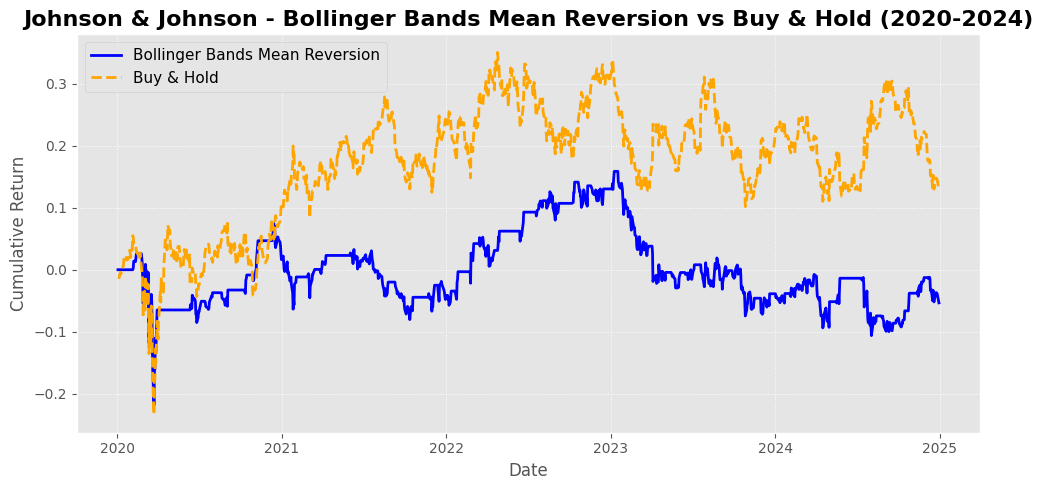

In [37]:
#Subset Johnson & Johnson
JNJ = df.groupby("Ticker").get_group("JNJ").copy() 
JNJ.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
JNJ["SMA"] = JNJ.Close.rolling(window=20).mean()
JNJ["Dev"] = JNJ.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
JNJ["UpperBand"] = JNJ.SMA + (2 * JNJ.Dev)
JNJ["LowerBand"] = JNJ.SMA - (2 * JNJ.Dev)

#Generate entry and exit signals 
JNJ["Signal"] = np.nan
signal = 0  
for row in range(1, len(JNJ)):
	close = JNJ.Close.iloc[row]
	prev_close = JNJ.Close.iloc[row-1]
	sma = JNJ.SMA.iloc[row]
	prev_sma = JNJ.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < JNJ.LowerBand.iloc[row]:
			JNJ.Signal.iloc[row] = 1
			signal = 1
		elif close > JNJ.UpperBand.iloc[row]:
			JNJ.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			JNJ.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			JNJ.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
JNJ.Signal = JNJ.Signal.ffill()

#No trade (0), if there is no signal 
JNJ.Signal = JNJ.Signal.fillna(0)

#Calculate the simple daily returns 
JNJ["Returns"] = JNJ.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
JNJ["Position"] = JNJ.Signal.shift()
JNJ["Strategy"] = JNJ.Returns * JNJ.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
JNJ["BBMR"] = (1 + JNJ.Strategy).cumprod() - 1
JNJ["BH"] = (1 + JNJ.Returns).cumprod() - 1 
print(JNJ.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(JNJ.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(JNJ.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Johnson & Johnson - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

Finally, we will apply the Bollinger Bands Mean Reversion strategy to Coca-Cola's stock:

           Ticker        BH      BBMR
Date                                 
2024-12-30     KO  0.317132  0.026954


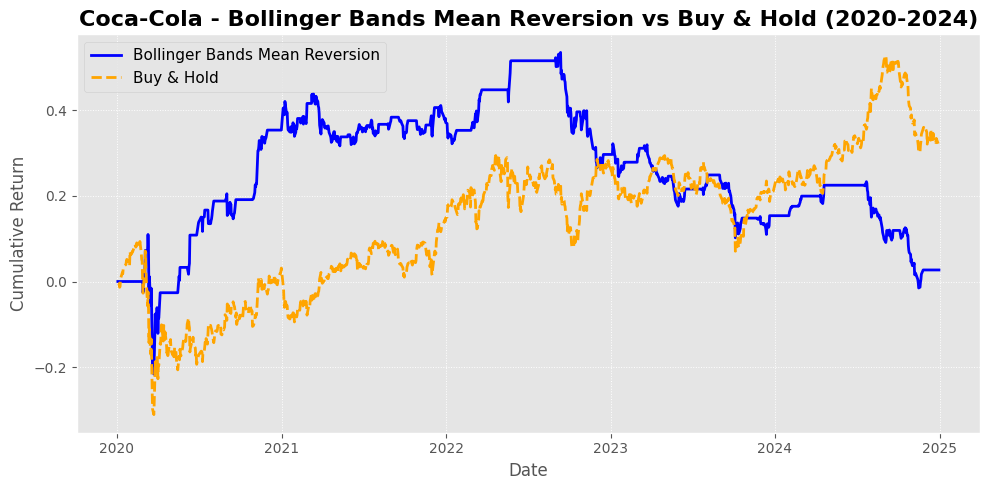

In [38]:
#Subset Coca-Cola
KO = df.groupby("Ticker").get_group("KO").copy() 
KO.set_index("Date", inplace=True)

#Calculate the middle Bollinger Band (SMA) and the standard deviation from the middle band 
KO["SMA"] = KO.Close.rolling(window=20).mean()
KO["Dev"] = KO.Close.rolling(window=20).std()

#Calculate the upper and lower Bollinger Bands 
KO["UpperBand"] = KO.SMA + (2 * KO.Dev)
KO["LowerBand"] = KO.SMA - (2 * KO.Dev)

#Generate entry and exit signals 
KO["Signal"] = np.nan
signal = 0  
for row in range(1, len(KO)):
	close = KO.Close.iloc[row]
	prev_close = KO.Close.iloc[row-1]
	sma = KO.SMA.iloc[row]
	prev_sma = KO.SMA.iloc[row-1]

	if signal == 0: #Whether to enter buy or sell
		if close < KO.LowerBand.iloc[row]:
			KO.Signal.iloc[row] = 1
			signal = 1
		elif close > KO.UpperBand.iloc[row]:
			KO.Signal.iloc[row] = -1
			signal = -1
	elif signal == 1: #Whether to exit buy
		if close >= sma and prev_close < prev_sma:
			KO.Signal.iloc[row] = 0
			signal = 0
	elif signal == -1: #Whether to exit sell
		if close <= sma and prev_close > prev_sma:
			KO.Signal.iloc[row] = 0
			signal = 0

#Hold until a signal change
KO.Signal = KO.Signal.ffill()

#No trade (0), if there is no signal 
KO.Signal = KO.Signal.fillna(0)

#Calculate the simple daily returns 
KO["Returns"] = KO.Close.pct_change()

#Calculate daily returns of the BBMR strategy 
KO["Position"] = KO.Signal.shift()
KO["Strategy"] = KO.Returns * KO.Position

#Calculate and compare cumulative BBMR strategy and B&H strategy returns
KO["BBMR"] = (1 + KO.Strategy).cumprod() - 1
KO["BH"] = (1 + KO.Returns).cumprod() - 1 
print(KO.tail(1)[["Ticker", "BH", "BBMR"]])

#Plot BBMR strategy and B&H strategy returns
plt.figure(figsize=(10, 5))
plt.plot(KO.BBMR, label = "Bollinger Bands Mean Reversion", color="blue", linewidth=2)
plt.plot(KO.BH, label = "Buy & Hold", color="orange", linewidth=2, linestyle="--")
plt.title("Coca-Cola - Bollinger Bands Mean Reversion vs Buy & Hold (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=11, frameon=True, loc="upper left")
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

# Portfolio Management

To gain a deeper understanding of the relationship between the daily returns of the different stocks in our porfolio, we will plot a correlation matrix. The darker the blue colour, the lower the correlation. The darker the red colour, the higher the  correlation. 

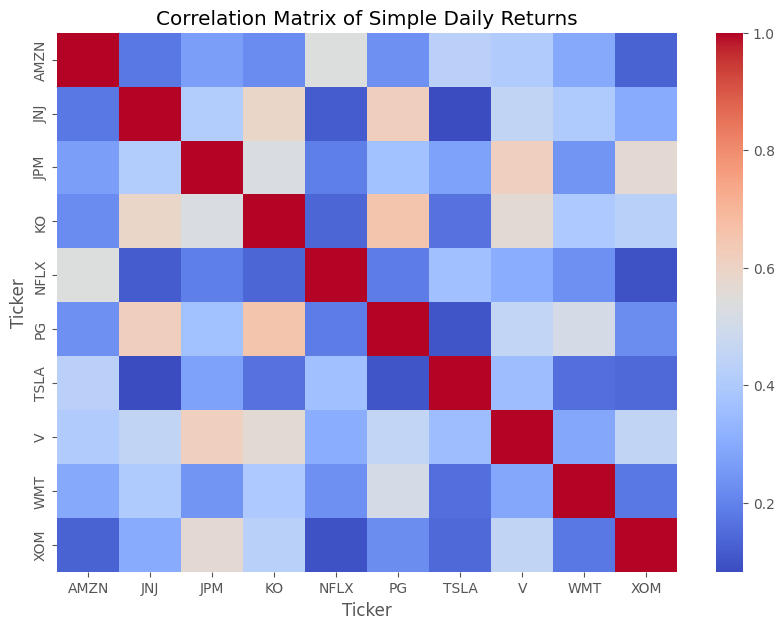

In [39]:
#Plot the correlation matrix 
correlation_matrix = pivot_df.pct_change().corr()
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", ax=ax)
ax.set_title("Correlation Matrix of Simple Daily Returns")
plt.show()

We will now create a portfolio that attaches equal weights to all 10 stocks and calculate the portfolio returns, cumulative returns and the daily standard deviation of the portfolio returns. 

In [40]:
#Create an equally-weighted portfolio 
portfolio_stocks = pivot_df.columns
pivot_df = pivot_df[portfolio_stocks]
weights = np.ones(10) / 10

# Calculate the simple return of each stock in the portfolio
returns = pivot_df.pct_change()
returns = returns.dropna()

#Calculate the portfolio returns
portfolio_returns = np.dot(returns, weights)

#Calculate cumulative return 
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

#Calculate the daily standard deviation of the portfolio returns
daily_std = portfolio_returns.std()


# Portfolio Optimisation

To optimise our portfolio, we will assign weights to the individual stocks so that the Sharpe Ratio is maximised. The greater the Sharpe Ratio, the higher the portfolio's return relative to its risk.  

The Sharpe Ratio is calculated as follows: 

$$ \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p} $$

- $R_p$ is the annualised portfolio return
- $R_f$ is the risk-free rate
- $\sigma_p$ is the annualised volatility

We will use the current 10-year U.S. Treasury Yield (4.25%) as a proxy for the risk-free rate. We will also assume that there are 252 trading days in a year. 


In [41]:
#Define the number of trading days in a year
trading_days = 252

#Calculate the annualised portfolio returns
annualised_returns = portfolio_returns.mean() * trading_days

#Calculate the annualised portfolio volatility
annualised_volatility = daily_std * np.sqrt(trading_days)

#Set the risk-free rate
RFR = 0.0425

#Calculate the Sharpe Ratio
sharpe = (annualised_returns - RFR) / annualised_volatility
print(f"The initial Sharpe Ratio is: {sharpe}")

#Define a function to calculate the negative Sharpe Ratio 
def negative_sharpe(weights):
    portfolio_returns = np.dot(returns, weights)
    annualised_returns = portfolio_returns.mean() * trading_days
    annualised_volatility = portfolio_returns.std() * np.sqrt(trading_days)

    sharpe_ratio = (annualised_returns - RFR) / annualised_volatility

    return -sharpe_ratio

#Set constraints
cons = {"type": "eq", "fun": lambda x: sum(x) - 1}

#Set bounds
bounds = tuple((0, 1) for x in range(10))

#Obtain optimal weights
init_weights = np.ones(10) / 10
optimal = minimize(negative_sharpe, init_weights, bounds=bounds, constraints=cons)
optimal_weights = optimal.x

#Calculate portfolio returns with optimal weights
optimal_portfolio_returns = np.dot(returns, optimal_weights)

#Calculate cumulative returns with optimal weights
optimal_cumulative_returns = (1 + optimal_portfolio_returns).cumprod() - 1

#Calculate the annualised return and volatility for the optimised portfolio
optimal_annualised_returns = optimal_portfolio_returns.mean() * trading_days
optimal_annualised_volatility = optimal_portfolio_returns.std() * np.sqrt(trading_days)

#Calculate the new Sharpe Ratio
optimal_sharpe = (optimal_annualised_returns - RFR) / optimal_annualised_volatility
print(f"The new Sharpe Ratio is: {optimal_sharpe}")

The initial Sharpe Ratio is: 0.9042985004510011
The new Sharpe Ratio is: 1.2298573446978895


There are also alternative ways to optimise the portfolio. The following portfolio optimisation strategies leveraging SciPy's "minimize" function were suggested by GitHub Copilot: 

1. Minimum Volatility Portfolio - find weights that minimise portfolio volatility (risk)
2. Maximum Return Portfolio - allocate all weight to the stock with the highest mean return
3. Risk Parity Portfolio - allocate weights so each stock contributes equally to portfolio risk

Out of these three strategies, we will implement the first one - the Minimum Volatility Portfolio - below. 


In [42]:
#Minimum Volatility Portfolio - find weights that minimise portfolio volatility (risk)

#Define a function to calculate the portfolio volatility for a given set of weights 
def minimum_volatility(weights):
    return np.dot(weights.T, np.dot(returns.cov(), weights)) ** 0.5 #returns.cov() calculates the covariance matrix of stock returns, ** 0.5 takes the square root of the portfolio variance to arrive at the standard deviation

#Set constraints
min_vol_cons = {"type": "eq", "fun": lambda x: sum(x) - 1}

#Set bounds
min_vol_bounds = tuple((0, 1) for x in range(10))

#Obtain optimal weights 
min_vol_optimal = minimize(minimum_volatility, init_weights, bounds=min_vol_bounds, constraints=min_vol_cons)
min_vol_optimal_weights = min_vol_optimal.x

#Calculate portfolio returns with optimal weights
min_vol_returns = np.dot(returns, min_vol_optimal_weights)

#Calculate cumulative returns with optimal weights
min_vol_cumulative_returns = (1 + min_vol_returns).cumprod() - 1

#Calculate the annualised return and volatility for the optimised portfolio
min_vol_annualised_returns = min_vol_returns.mean() * trading_days
min_vol_annualised_volatility = min_vol_returns.std() * np.sqrt(trading_days)

#Calculate the new Sharpe Ratio
min_vol_sharpe = (min_vol_annualised_returns - RFR) / min_vol_annualised_volatility
print(f"The Minimum Volatility Portfolio Sharpe Ratio is: {min_vol_sharpe}")

The Minimum Volatility Portfolio Sharpe Ratio is: 0.49361350496543854


Finally, let's plot the cumulative Sharpe Ratio optimsed portfolio returns, the cumulative minimum volatility portfolio returns, and the cumulative equally-weighted portfolio returns for comparison.

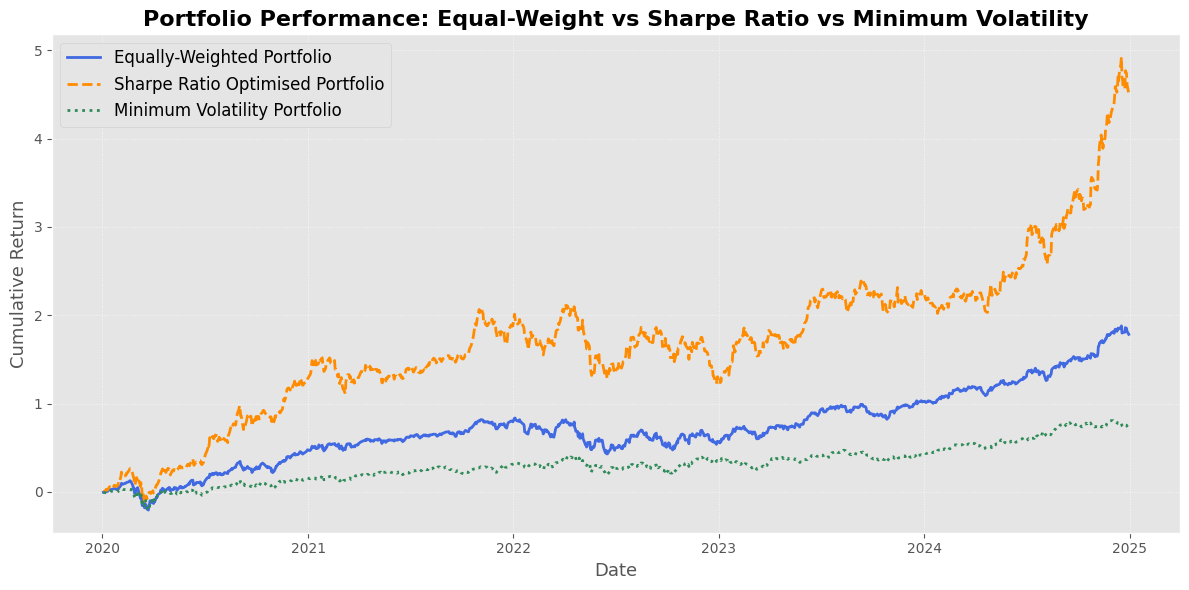

In [43]:
#Match number of values in data frame to number of return values 
dates = pivot_df.index[1:]

#Plot
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_returns, label="Equally-Weighted Portfolio", color="royalblue", linewidth=2)
plt.plot(dates, optimal_cumulative_returns, label="Sharpe Ratio Optimised Portfolio", color="darkorange", linewidth=2, linestyle="--")
plt.plot(dates, min_vol_cumulative_returns, label="Minimum Volatility Portfolio", color="seagreen", linewidth=2, linestyle=":")
plt.legend(fontsize=12, frameon=True, loc="upper left")
plt.title("Portfolio Performance: Equal-Weight vs Sharpe Ratio vs Minimum Volatility", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=13)
plt.ylabel("Cumulative Return", fontsize=13)
plt.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# Reporting
With respect to cumulative returns, the above plot shows that the Sharpe Ratio optimised portfolio performs the best, followed by the equally weighted portfolio and the minimum volatility portfolio in last place. This suggests that, if the main objective is to maximise cumulative returns, the Sharpe Ratio optimised portfolio is recommended. However, by contrast, if the aim is to obtain a portfolio with minimal risk, the minimum volatility portfolio may be favoured. Naturally, the reduced risk of this portfolio will come at the expense of lower returns. In short, the recommended portfolio optimisation choice depends on whether risk or return is prioritised. The optimal weights for both strategies are as follows:  

In [44]:
#Optimal weights of Sharpe Ratio and minimum volatility portfolios
weights_table = pd.DataFrame({
    "Ticker": portfolio_stocks,
    "Sharpe Ratio Optimised Weights": optimal_weights,
    "Minimum Volatility Weights": min_vol_optimal_weights
})
print(weights_table)

  Ticker  Sharpe Ratio Optimised Weights  Minimum Volatility Weights
0   AMZN                    9.406614e-18                6.462521e-02
1    JNJ                    0.000000e+00                3.364209e-01
2    JPM                    1.755647e-17                0.000000e+00
3     KO                    0.000000e+00                1.653607e-01
4   NFLX                    5.468770e-02                3.346642e-02
5     PG                    0.000000e+00                1.174332e-01
6   TSLA                    3.072091e-01                2.710505e-20
7      V                    3.623442e-17                8.944668e-18
8    WMT                    5.173522e-01                2.165480e-01
9    XOM                    1.207509e-01                6.614554e-02


It is worth emphasising again that the minimum volatility portfolio optimisation strategy was recommended by GitHub Copilot. The AI-generated code was clear, as it followed a syntax similar to the one of the Sharpe Ratio optimisation code. By making small adjustments, including adapting some variable names, and adjusting the style of quotation marks, the suggested code was easily integrated into the notebook. 

Having implemented the Bollinger Bands Mean Reversion (BBMR) strategy for each of the 10 stocks, notably, for none of them this strategy performed better than simply buying and holding (B&H) the security for the 2020-2024 period. While there are companies, such as Visa, for which the strategy reached similar levels of cumulative returns to those of the B&H strategy (Visa: 0.709 vs 0.701), for most stocks the BBMR strategy performed significantly worse (e.g., Tesla: 13.552 vs -0.958). Therefore, if we expect future stock movements to follow a pattern similar to that of the historical data, the BBMR is not recommended for any of the 10 stocks. 

Overall, the 10-stock portfolio seems like a worthwhile investment. The mostly blue-coloured correlation matrix reflects, at least partly, the different industries within which the 10 companies operate - the returns of the individual stocks are little correlated, improving the potential for reduced portfolio volatility. The stocks have also been performing well individually, with all B&H cumulative returns being positive for the 2020-2024 period. 